# COVID-19 

In this notebook we will go through the developments around the COVID-19 virus infections. First we look at the developments worldwide and finally EU only.

The dataset which I use in this project is provided by the [`European Centre for Disease Prevention and Control (ECDC)`](https://www.ecdc.europa.eu/en/geographical-distribution-2019-ncov-cases)

* Author: Erfan Nariman
* Date: 10-03-2020
* GitHub: [erfannariman](github.com/ErfPy)

---

In [1]:
import pandas as pd
import os
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
pd.set_option('display.max_columns', None)

---

### data import

In [2]:
df = pd.read_excel(os.path.join('..', 'data', 'COVID-19-geographic-disbtribution-worldwide-2020-03-10.xls'))

df.shape

(4652, 6)

### data cleaning

In [3]:
# we filter out China to get rid of the extreme values
df = df[df['CountryExp'].ne('China')]

# clean up column names
df.columns = df.columns.str.replace('DateRep', 'Date').str.replace('CountryExp', 'Country')

# convert Date column to datetime type
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

# replace name to Japan
df['Country'] = df['Country'].str.replace('Cases on an international conveyance Japan', 'Japan')

# print first 5 rows of dataframe
df.head()

,Date,Country,NewConfCases,NewDeaths,GeoId,EU
0,2020-03-08,Afghanistan,3,0,AF,Non-EU/EEA
1,2020-03-02,Afghanistan,0,0,AF,Non-EU/EEA
2,2020-03-01,Afghanistan,0,0,AF,Non-EU/EEA
3,2020-02-29,Afghanistan,0,0,AF,Non-EU/EEA
4,2020-02-28,Afghanistan,0,0,AF,Non-EU/EEA


### exploratory data analysis (EDA)

In [4]:
# range of data in days
df['Date'].max() - df['Date'].min()

Timedelta('70 days 00:00:00')

In [5]:
# checking for missing days by resampling and checking for NaN
df.set_index('Date').resample('D').mean().isna().sum()

NewConfCases    0
NewDeaths       0
dtype: int64

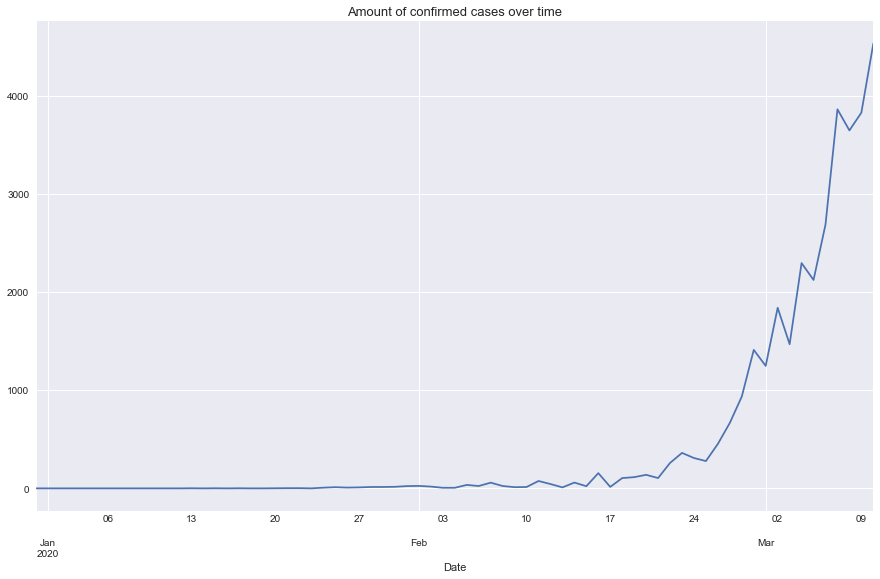

In [6]:
cases_sum = df.groupby('Date')['NewConfCases'].sum()
cases_sum.plot(figsize=(15,9))
plt.title('Amount of confirmed cases over time', size=13)
plt.savefig('../plots/plt1.png', dpi=100)
plt.show()

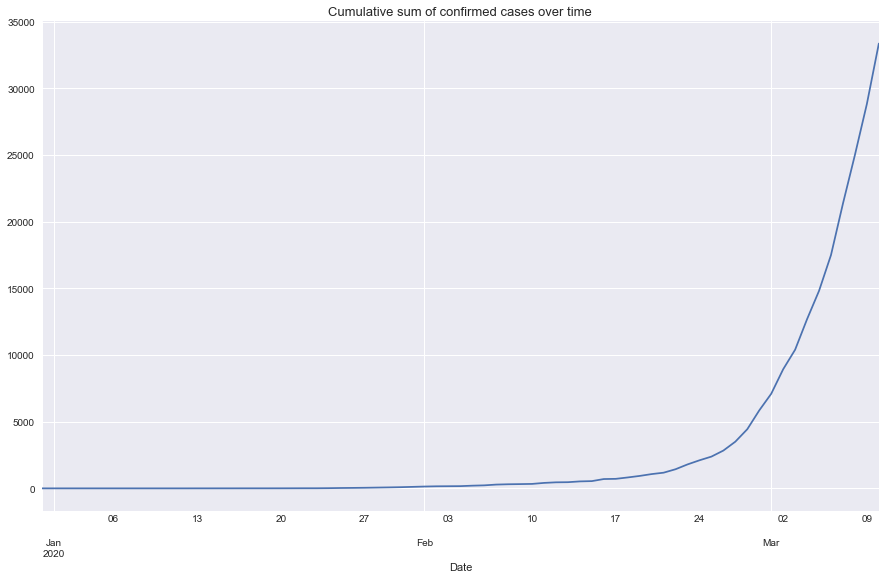

In [7]:
cases_cumsum = cases_sum.cumsum()
cases_cumsum.plot(figsize=(15,9))
plt.title('Cumulative sum of confirmed cases over time', size=13)
plt.savefig('../plots/plt2.png')
plt.show()

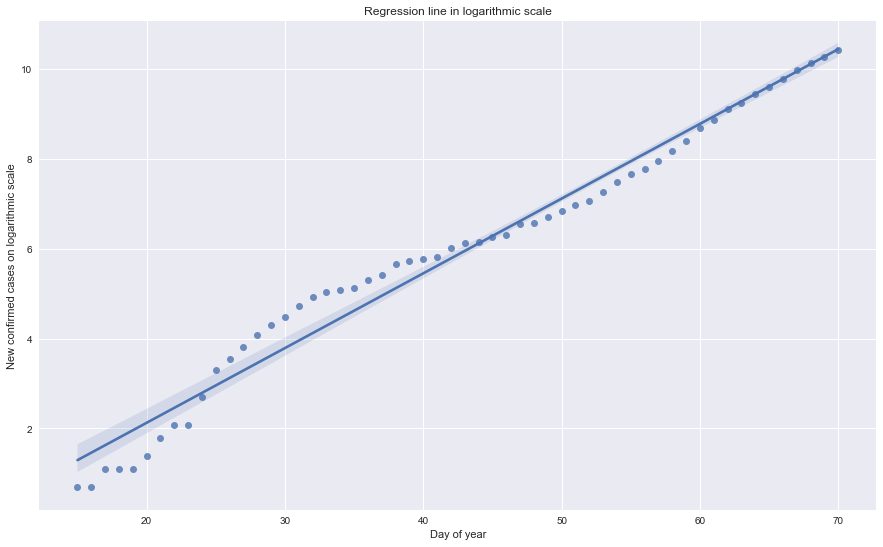

In [8]:
log_cumsum = np.log(cases_cumsum[cases_cumsum.gt(1)]).to_frame().reset_index()
log_cumsum['Date'] = log_cumsum['Date'].dt.dayofyear

plt.figure(figsize=(15,9))
plt.title("Regression line in logarithmic scale")
sns.regplot(x='Date', y='NewConfCases', data=log_cumsum)
plt.xlabel('Day of year')
plt.ylabel('New confirmed cases on logarithmic scale')
plt.savefig('../plots/plt3.png')
plt.show()

In [9]:
X = log_cumsum['Date']
y = log_cumsum['NewConfCases']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           NewConfCases   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                              6238.
Date:                Tue, 10 Mar 2020   Prob (F-statistic):                    2.65e-58
Time:                        17:22:47   Log-Likelihood:                         -51.280
No. Observations:                  56   AIC:                                      104.6
Df Residuals:                      55   BIC:                                      106.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Date           0.1416      0.002     78.983      0.000       0.138       0.145
==============================================================================
Omnibus:                       13.715   Durbin-Watson:                   0.046
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.299
Skew:                          -1.257   Prob(JB):                     0.000476
Kurtosis:                       3.491   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

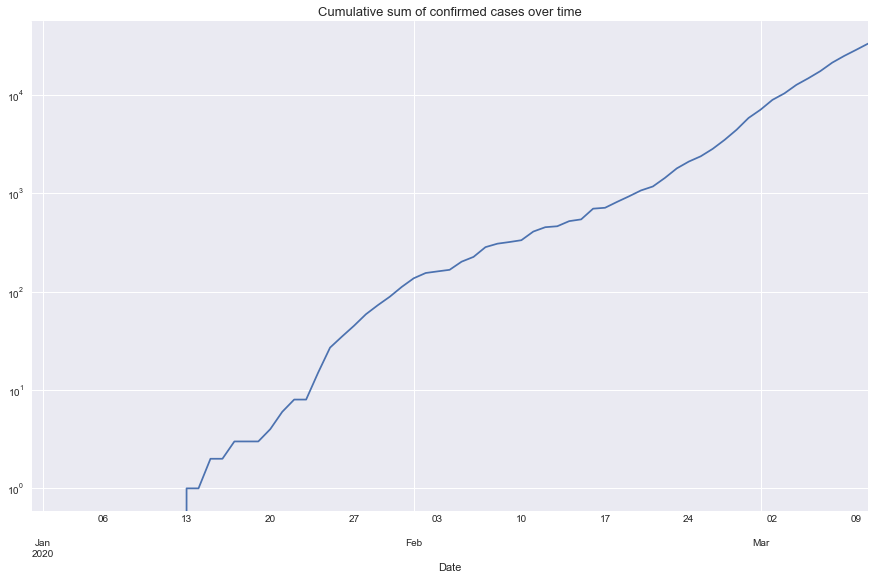

In [10]:
cases_cumsum.plot(figsize=(15,9), logy=True)
plt.title('Cumulative sum of confirmed cases over time', size=13)
plt.savefig('../plots/plt4.png')
plt.show()

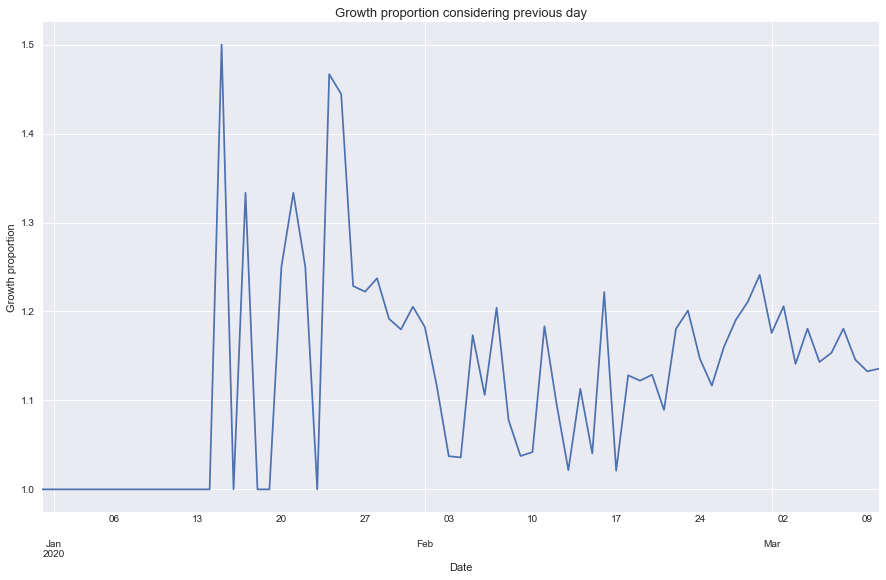

In [11]:
cases_cumsum = cases_cumsum.replace(0, 1)
cases_cumsum.diff().div(cases_cumsum).add(1).fillna(1).plot(figsize=(15,9))
plt.title('Growth proportion considering previous day', size=13)
plt.ylabel('Growth proportion')
plt.savefig('../plots/plt5.png')
plt.show()

In [18]:
df.groupby('Country')['NewConfCases'].max().sort_values(ascending=False).head(15)

Country
Italy                       1797
Iran                        1234
South Korea                  909
Spain                        615
France                       410
Germany                      284
United States of America     200
Japan                        134
Switzerland                  122
Netherlands                   77
Sweden                        76
Denmark                       75
United Kingdom                67
Belgium                       60
Norway                        34
Name: NewConfCases, dtype: int64

In [19]:
df.groupby('Country')['NewConfCases'].sum().sort_values(ascending=False).head(15)

Country
Italy                       9172
South Korea                 7513
Iran                        7161
France                      1412
Japan                       1210
Spain                       1204
Germany                     1139
United States of America     754
Switzerland                  374
United Kingdom               321
Netherlands                  321
Sweden                       248
Belgium                      239
Norway                       192
Singapore                    160
Name: NewConfCases, dtype: int64

### time series analysis

In [24]:
from itertools import product

p = d = q = range(0, 2)
pdq = list(product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(p, d, q))]

In [47]:
y = cases_cumsum
y.index = pd.DatetimeIndex(y.index.values,
                           freq=y.index.inferred_freq)

results_list = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            results_list.append((param, param_seasonal, results.aic))
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1451.7755018732412
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1180.6100902654898
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1201.7478968189666
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:948.2934066214207
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:988.3734774661277
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:974.3871604617271
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:803.8543093976617
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:789.1528725281651
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1386.4491585374155
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1149.6481101508693
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1145.127230434017
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:882.3437208778623
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:940.6010923621973


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:913.8754707569304
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:773.481675949425


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:740.3893564133291
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1170.473907175081
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:973.3509055038894
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:965.6825398651647
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:770.4906864710706
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:868.368228453285
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:851.8205380226611
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:711.3827267195778
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:697.4705943582771
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:1088.931399611216
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:908.5507389700931
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:900.0092830310559
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:718.3326196978795
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:867.5361477002825
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:837.8756001507672
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:710.3186085852883
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:682.1421661669756
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:935.6280615830533
ARIMA(1, 0,

C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:779.2353556773863
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:782.599147167481
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:627.7065155861698
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:774.6814950630803
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:853.4400537911089


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:624.2833216802032


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:613.8189918540077
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:936.801874190788
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:786.7473053295729
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:793.4969384963899
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:636.9884051359479
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:783.1728678726001
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:785.098514324976
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:628.8227472943126
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:630.8246514709145
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:900.2946846501555
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:754.6200201950475
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:761.4764984016624
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:609.0061947487692
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:763.8554466757073
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:753.2860101112425
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:614.3325584152409
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:603.378024293977


In [48]:
min([aic for x, y, aic in results_list if aic > 0])

603.378024293977

In [27]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1592      0.008    139.837      0.000       1.143       1.175
ma.L1         -0.6914      0.134     -5.161      0.000      -0.954      -0.429
ar.S.L12      -2.4146      0.893     -2.704      0.007      -4.165      -0.664
ma.S.L12      -0.0312      0.703     -0.044      0.965      -1.410       1.348
sigma2      4.543e+04   7075.757      6.421      0.000    3.16e+04    5.93e+04


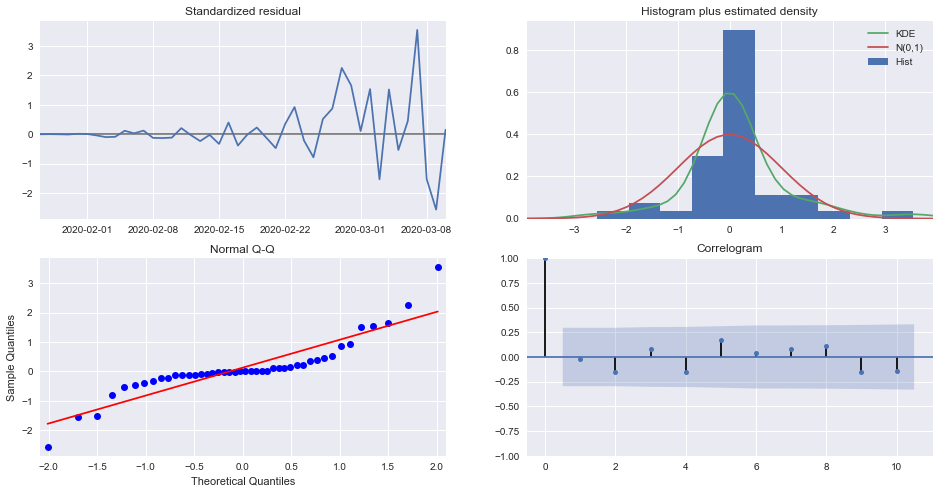

In [28]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

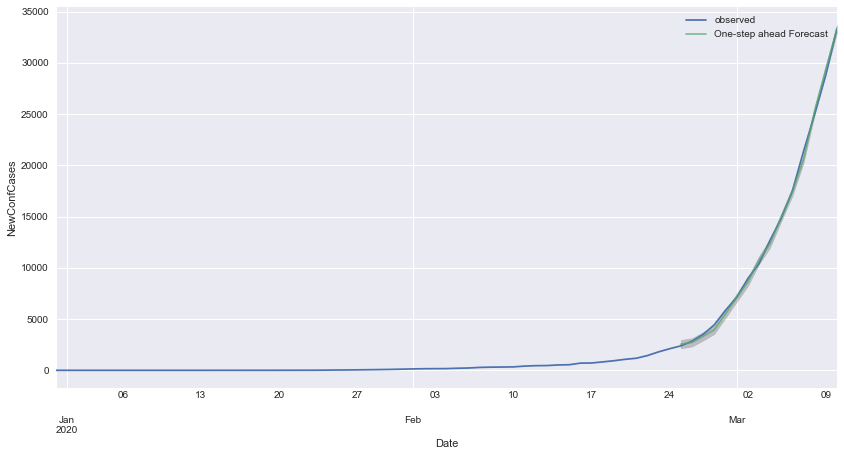

In [35]:
pred = results.get_prediction(start=(y.index.max() - pd.Timedelta(days=14)), dynamic=False)
pred_ci = pred.conf_int()
ax = y.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('NewConfCases')
plt.legend()
plt.show()

In [36]:
y_forecasted = pred.predicted_mean
y_truth = y[(y.index.max() - pd.Timedelta(days=14)):]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 116531.03


In [37]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 341.37


In [44]:
pred_ci

,lower NewConfCases,upper NewConfCases
2020-03-11,38246.448521,39081.977147
2020-03-12,43206.335893,44690.246363
2020-03-13,49719.332437,51960.342757
2020-03-14,56671.432583,59814.933274
2020-03-15,65685.819470,69904.236949


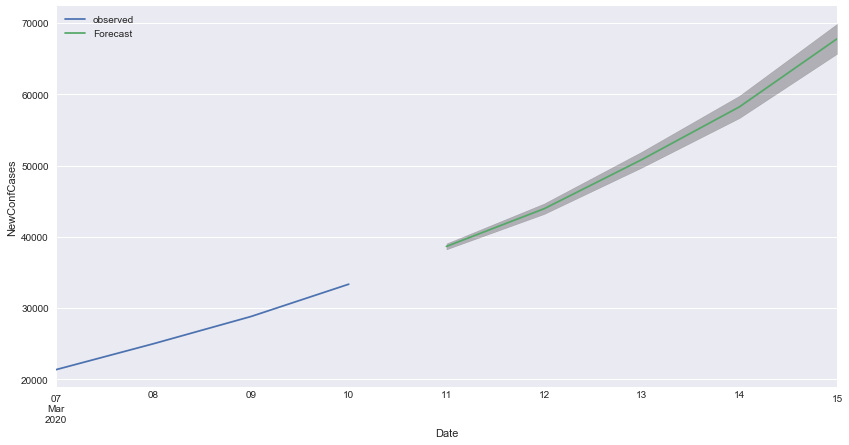

In [46]:
pred_uc = results.get_forecast(steps=5)
pred_ci = pred_uc.conf_int()
ax = y[(y.index.max() - pd.Timedelta(days=3)):].plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('NewConfCases')
plt.legend()
plt.show()

In [43]:
# TODO: check why theres a gap between forecast

---